# 1. Mount Google Drive & Path

In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = "/content/drive/My Drive/Colab Notebooks/SistemTemuKembaliInformasi/Minggu9/"

Mounted at /content/drive


# 2. Install & Import Library

In [2]:
!pip install ekphrasis sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 5.6 MB/s eta 0:00:00


In [3]:
import re, string, nltk, joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# 3. Load Dataset

In [4]:
df = pd.read_csv(BASE_PATH + "Dataset_Sentimen_Emosi.csv")
df = df.drop(columns=["Emosi"])
df.head()

,Tweet,Sentimen
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0
4,Covid belum nyampe prigen mbak hmm hoax,0.0


# 4. Text Preprocessing

In [5]:
text_processor = TextPreProcessor(
    normalize=['number', 'user', 'url'],
    annotate={"hashtag","allcaps","elongated","repeated"},
    fix_html=True,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

def clean_text(text):
    text = " ".join(text_processor.pre_process_doc(text))
    text = text.lower()
    text = re.sub(r"http\S+|@\S+|#\S+", " ", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    return " ".join(text.split())

df["step01"] = df["Tweet"].astype(str).apply(clean_text)
df.head()

/usr/local/lib/python3.12/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt


/usr/local/lib/python3.12/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


,Tweet,Sentimen,step01
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0,emang lemes bgt ya mulut lu gue yg mau beli be...
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...
4,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax


# 5. Tokenisasi, Normalisasi & Stopword

In [6]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stopword = stopwords.words('indonesian')

df["tokens"] = df["step01"].apply(word_tokenize)
df["tokens"] = df["tokens"].apply(lambda x: [w for w in x if w not in stopword])
df["step02"] = df["tokens"].apply(lambda x: " ".join(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 6. Stemming

In [7]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer = StemmerFactory().create_stemmer()

df["ProcessedText"] = df["step02"].apply(stemmer.stem)
df.head()

,Tweet,Sentimen,step01,tokens,step02,ProcessedText
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0,emang lemes bgt ya mulut lu gue yg mau beli be...,"[emang, lemes, bgt, ya, mulut, lu, gue, yg, be...",emang lemes bgt ya mulut lu gue yg beli beli o...,emang lemes bgt ya mulut lu gue yg beli beli o...
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...,"[cegah, mata, rantai, covid, number, mari, dir...",cegah mata rantai covid number mari dirumah mi...,cegah mata rantai covid number mari rumah ming...
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...,"[mohon, yaallah, semoga, wabah, covid, number,...",mohon yaallah semoga wabah covid number menghi...,mohon yaallah moga wabah covid number hilang r...
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...,"[pemprov, papua, naikkan, status, tanggap, dar...",pemprov papua naikkan status tanggap darurat c...,pemprov papua naik status tanggap darurat covi...
4,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax,"[covid, nyampe, prigen, mbak, hmm, hoax]",covid nyampe prigen mbak hmm hoax,covid nyampe prigen mbak hmm hoax


# 7. Simpan Dataset Bersih

In [8]:
df.to_csv(BASE_PATH + "clean_dataset_part01.csv", sep=";", index=False)

# 8. Persiapan Data

In [16]:
dataset = pd.read_csv(BASE_PATH + "clean_dataset_part01.csv", sep=";")

# Hapus data bermasalah / NaN
dataset = dataset.dropna(subset=["Sentimen"])

X = dataset["ProcessedText"].astype(str)
y = dataset["Sentimen"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 9. Naive Bayes + TF-IDF

In [17]:
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB())
])

params_nb = {
    'tfidf__ngram_range': [(1,2)],
    'model__alpha': [0.1, 1]
}

grid_nb = GridSearchCV(pipeline_nb, params_nb, cv=3)
grid_nb.fit(X_train, y_train)

y_pred_nb = grid_nb.predict(X_test)

In [18]:
print("NB Accuracy :", accuracy_score(y_test, y_pred_nb))
print("NB Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("NB Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("NB F1       :", f1_score(y_test, y_pred_nb, average='weighted'))

NB Accuracy : 0.5955882352941176
NB Recall   : 0.5955882352941176
NB Precision: 0.5901225490196078
NB F1       : 0.5531730363449792


# 10. KNN + TF-IDF

In [19]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_tfidf, y_train)

y_pred_knn = knn.predict(X_test_tfidf)

In [20]:
print("KNN Accuracy :", accuracy_score(y_test, y_pred_knn))
print("KNN Recall   :", recall_score(y_test, y_pred_knn, average='weighted'))
print("KNN Precision:", precision_score(y_test, y_pred_knn, average='weighted'))
print("KNN F1       :", f1_score(y_test, y_pred_knn, average='weighted'))

KNN Accuracy : 0.5955882352941176
KNN Recall   : 0.5955882352941176
KNN Precision: 0.5946794498591226
KNN F1       : 0.5929348909130949


# 11. Confusion Matrix

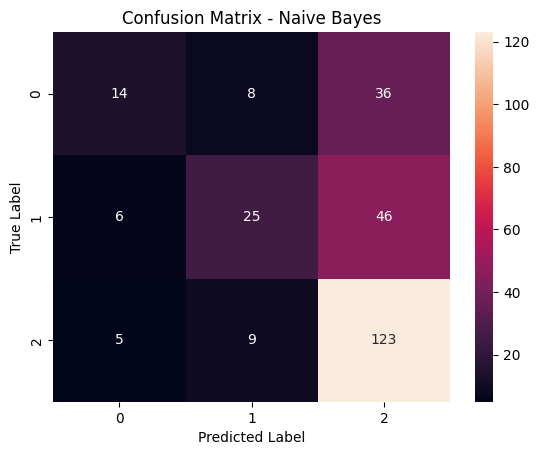

In [24]:
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt="d")
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

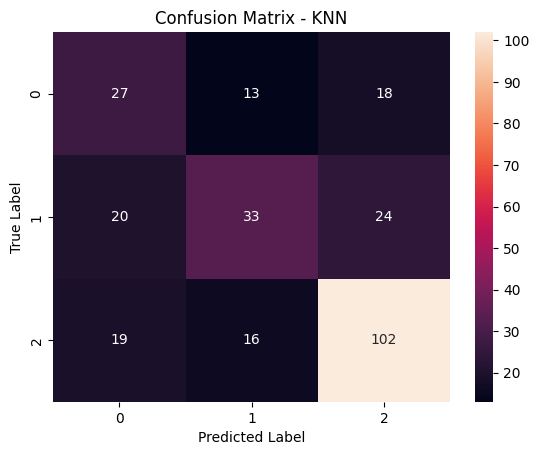

In [25]:
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt="d")
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 12. Perbandingan Model

In [26]:
comparison = pd.DataFrame({
    "Model": ["Naive Bayes", "KNN"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_knn)
    ]
})

comparison

,Model,Accuracy
0,Naive Bayes,0.595588
1,KNN,0.595588


# 13. Simpan Model

In [27]:
joblib.dump(grid_nb.best_estimator_, BASE_PATH + "model_naive_bayes.joblib")

['/content/drive/My Drive/Colab Notebooks/SistemTemuKembaliInformasi/Minggu9/model_naive_bayes.joblib']

# 14. Kesimpulan

### Berdasarkan hasil evaluasi, model Naive Bayes dan KNN menghasilkan nilai akurasi yang sama, yaitu 59,56%, yang menunjukkan bahwa kedua metode memiliki kemampuan klasifikasi yang sebanding pada dataset ini. Hal ini mengindikasikan bahwa karakteristik data teks dan fitur TF-IDF yang digunakan belum memberikan keunggulan signifikan bagi salah satu model. Oleh karena itu, performa model masih dipengaruhi oleh kompleksitas data dan keterbatasan metode yang digunakan.